<a href="https://colab.research.google.com/github/Maheshtippanu/Voice_over_alerts_DL/blob/main/Voice_Over_Alerts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install librosa tensorflow numpy pandas matplotlib seaborn scikit-learn


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maheshtippanu9506","key":"ce7b76d2f736cde9ad36d88c7ca2d150"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d chrisfilo/urbansound8k


Dataset URL: https://www.kaggle.com/datasets/chrisfilo/urbansound8k
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
... resuming from 1272971264 bytes (4753261260 bytes left) ...
100% 5.61G/5.61G [01:00<00:00, 31.4MB/s]
100% 5.61G/5.61G [01:00<00:00, 78.3MB/s]


In [ ]:
!unzip urbansound8k.zip -d UrbanSound8K


Streaming output truncated to the last 5000 lines.
  inflating: UrbanSound8K/fold4/151877-5-1-0.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-0.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-1.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-10.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-11.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-12.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-13.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-14.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-15.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-16.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-17.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-18.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-19.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-2.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-20.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-21.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-3.wav  
  inflating: UrbanSound8K/fold4/154758-5-0-4.wav  
  inflating: UrbanS

In [ ]:
!ls UrbanSound8K


fold1  fold10  fold2  fold3  fold4  fold5  fold6  fold7  fold8	fold9  UrbanSound8K.csv


In [ ]:
pwd

'/content'

In [ ]:
ls /content

kaggle.json  sample_data/  UrbanSound8K/  urbansound8k.zip


In [ ]:
import os

# Check if the UrbanSound8K folder exists
os.listdir('/content/UrbanSound8K')

['fold4',
 'fold8',
 'fold10',
 'fold6',
 'fold7',
 'fold2',
 'fold9',
 'UrbanSound8K.csv',
 'fold1',
 'fold3',
 'fold5']

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
# Path to the metadata
metadata_path = '/content/UrbanSound8K/UrbanSound8K.csv'
df = pd.read_csv(metadata_path)

# Display the first few rows
print(df.head())


      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [ ]:
# Function to extract Mel Spectrogram
def extract_mel_spectrogram(file_path, n_mels=128, hop_length=512):
    try:
        y, sr = librosa.load(file_path, sr=None)  # Load audio file
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB
        return mel_spec_db
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
import cv2

# Parameters
audio_dir = '/content/UrbanSound8K'
IMG_SIZE = (128, 128)  # Resize target

# Store features and labels
features = []
labels = []

for index, row in df.iterrows():
    file_path = os.path.join(audio_dir, f"fold{row['fold']}", row['slice_file_name'])

    if os.path.exists(file_path):
        mel_spec = extract_mel_spectrogram(file_path)

        if mel_spec is not None:
            # Resize the spectrogram to ensure consistent dimensions
            mel_spec_resized = cv2.resize(mel_spec, IMG_SIZE)

            # Normalize (scaling pixel values between 0 and 1)
            mel_spec_normalized = (mel_spec_resized - np.min(mel_spec_resized)) / (np.max(mel_spec_resized) - np.min(mel_spec_resized))

            features.append(mel_spec_normalized)
            labels.append(row['classID'])  # Using classID as label
    else:
        print(f"File not found: {file_path}")

# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels)

# Add channel dimension (for CNN compatibility)
X = X.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Features shape: (8732, 128, 128, 1)
Labels shape: (8732,)


In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (6985, 128, 128, 1)
Test set shape: (1747, 128, 128, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# Input shape
input_shape = (128, 128, 1)  # Matching the spectrogram dimensions

# CNN Architecture
model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Flattening Layer
    Flatten(),

    # Fully Connected Layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting

    # Output Layer (10 classes for UrbanSound8K)
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,250 (12.61 MB)

 Trainable params: 3,305,802 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.2786 - loss: 3.3159 - val_accuracy: 0.1145 - val_loss: 17.8545
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.3232 - loss: 2.1091 - val_accuracy: 0.3017 - val_loss: 5.6291
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3809 - loss: 1.7980 - val_accuracy: 0.4596 - val_loss: 1.5679
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4310 - loss: 1.6257 - val_accuracy: 0.5180 - val_loss: 1.7116
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4677 - loss: 1.5210 - val_accuracy: 0.2936 - val_loss: 4.1569
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5236 - loss: 1.3348 - val_accuracy: 0.6113 - val_loss: 1.1729
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5260 - loss: 1.4062 - val_accuracy: 0.5999 - val_loss: 1.0962
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5803 - loss: 1.1658 - val_a

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5969 - loss: 1.0764
Test Accuracy: 59.99%


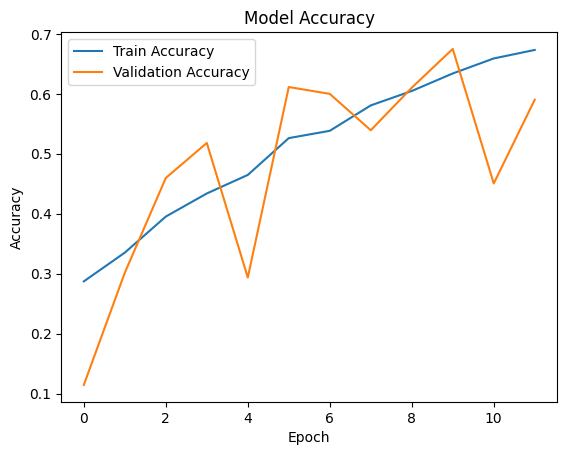

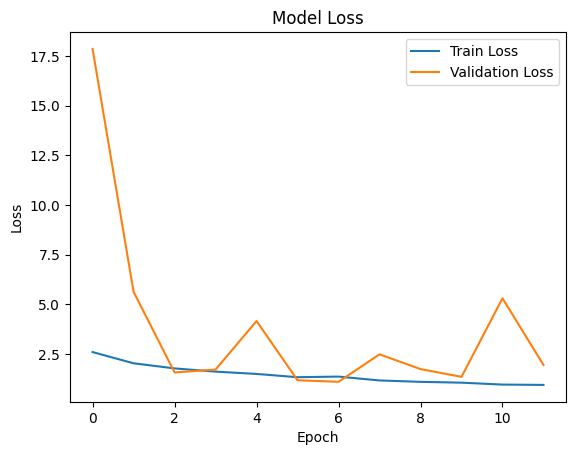

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load ResNet50 without top layer
base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

# Add custom layers on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,581,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,845,002 (90.96 MB)

 Trainable params: 23,791,882 (90.76 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,048,991 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,249 (16.08 MB)

 Trainable params: 4,172,230 (15.92 MB)

 Non-trainable params: 42,019 (164.14 KB)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.1263 - loss: 2.3026
Test Loss: 2.302583694458008
Test Accuracy: 0.11448197066783905


In [ ]:
model.save('cnn_model.keras')


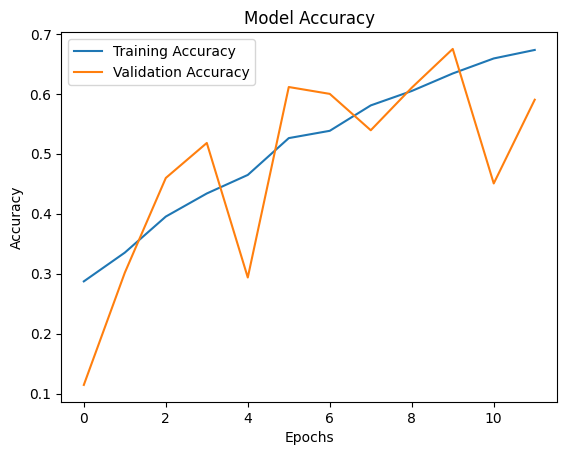

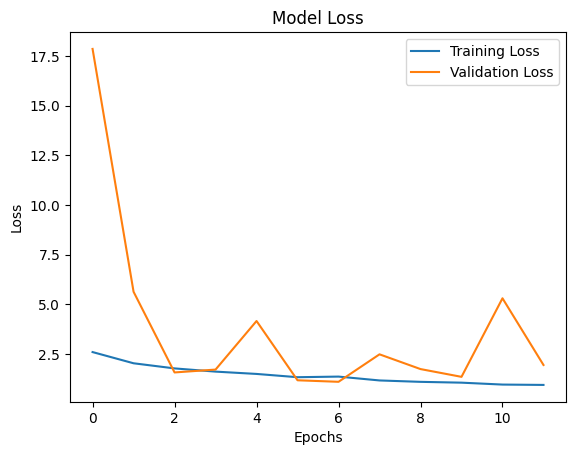

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image  # Import the PIL library


# Example function to preprocess an audio file into a spectrogram
def preprocess_audio(file_path, target_size=(128, 128)):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Convert audio to a spectrogram
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

    # Resize the spectrogram to the target size (128x128 in this case)
    # Convert the spectrogram to a PIL Image for resizing
    image = Image.fromarray(D)
    D_resized = np.array(image.resize(target_size))

    # Normalize the image (if necessary)
    D_resized = D_resized / np.max(D_resized)

    # Convert to the correct shape for CNN input (height, width, channels)
    D_resized = np.expand_dims(D_resized, axis=-1)  # Add channel dimension

    return D_resized

# Example usage
# Replace 'path_to_audio_sample.wav' with the actual path to your audio file
new_audio_file = '/content/UrbanSound8K/fold1/101415-3-0-2.wav' # Updated with an existing file path
processed_sample = preprocess_audio(new_audio_file)

<ipython-input-50-4e8a80a26b43>:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


In [ ]:
# Assuming the model is loaded and ready
model = tf.keras.models.load_model('cnn_model.keras')  # If not already loaded

# Prepare the new sample for prediction
processed_sample = np.expand_dims(processed_sample, axis=0)  # Add batch dimension

# Make prediction
predictions = model.predict(processed_sample)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=-1)

print(f"Predicted class: {predicted_class}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 217 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted class: [1]


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image  # Import the PIL library
import os
import pandas as pd

# Assuming the model is loaded and ready
model = tf.keras.models.load_model('cnn_model.keras')  # If not already loaded

# --- Prepare New Test Data ---
# Define path to new test data - Update this with your actual path
# new_test_data_path = '/path/to/your/new/test/data'
new_test_data_path = '/content/UrbanSound8K/fold1' # Update to an existing folder with .wav files

# Function to preprocess audio for new data (same as before)
def preprocess_audio(file_path, target_size=(128, 128)):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Convert audio to a spectrogram
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

    # Resize the spectrogram
    image = Image.fromarray(D)
    D_resized = np.array(image.resize(target_size))

    # Normalize the image
    D_resized = D_resized / np.max(D_resized)

    # Add channel dimension
    D_resized = np.expand_dims(D_resized, axis=-1)

    return D_resized

# --- Load and Preprocess New Test Data ---
X_test_new = []
y_test_new = []

# Assuming your new test data has a similar structure to the original
# (e.g., audio files in folders with corresponding labels)
for filename in os.listdir(new_test_data_path):
    if filename.endswith(".wav"):  # Adjust file extension if needed
        file_path = os.path.join(new_test_data_path, filename)
        processed_sample = preprocess_audio(file_path)
        X_test_new.append(processed_sample)

        # Extract label from filename (adapt to your naming convention)
        # label = int(filename.split('-')[1])  # Example: assuming '101415-3-0-2.wav'
        # Assuming filenames in 'fold1' follow pattern 'xxxxxxxx-y-z-w.wav', label is 'y'
        label = int(filename.split('-')[1])
        y_test_new.append(label)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)


# --- Evaluate Model on New Test Data ---
test_loss, test_acc = model.evaluate(X_test_new, y_test_new)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 217 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
<ipython-input-56-143203adc8e3>:23: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.0450 - loss: 2.3026
Test Loss: 2.3025853633880615
Test Accuracy: 0.04123711213469505


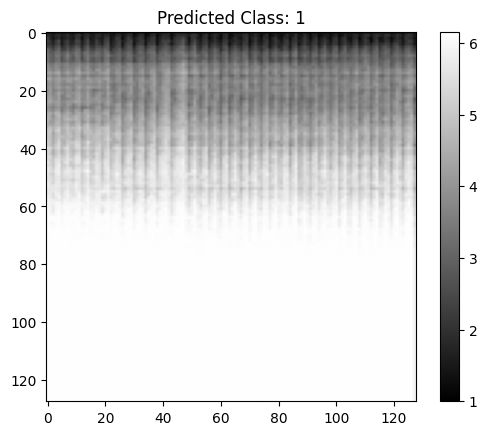

In [ ]:
# Plot the spectrogram and the predicted class
plt.imshow(processed_sample[:, :, 0], cmap='gray')  # Remove the extra index [0, ...]
plt.title(f"Predicted Class: {predicted_class[0]}") # predicted_class is an array, get the first element
plt.colorbar()
plt.show()